In [1]:
import numpy as np
import pandas as pd
import pegasus as pg
import json
import os
import pegasusio
from pegasusio import UnimodalData, MultimodalData
import matplotlib.pyplot as plt 
import itertools
from matplotlib import cm
import seaborn as sns
import matplotlib.colors
from scipy.sparse import issparse
from pandas.api.types import is_numeric_dtype, is_categorical_dtype, is_list_like
from scipy.stats import zscore
from sklearn.metrics import adjusted_mutual_info_score
from natsort import natsorted
import anndata
from typing import List, Tuple, Union, Optional, Callable
from pegasus.tools import X_from_rep, slicing

In [3]:
data = pg.read_input('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/RNA/data/RNA_FINAL.zarr')
data

2023-09-30 14:09:40,735 - pegasusio.readwrite - INFO - zarr file '/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/RNA/data/RNA_FINAL.zarr' is loaded.
2023-09-30 14:09:40,735 - pegasusio.readwrite - INFO - Function 'read_input' finished in 531.46s.


MultimodalData object with 1 UnimodalData: 'GRCh38-rna'
    It currently binds to UnimodalData object GRCh38-rna

UnimodalData object with n_obs x n_vars = 935371 x 27982
    Genome: GRCh38; Modality: rna
    It contains 2 matrices: 'X', 'raw.X'
    It currently binds to matrix 'X' as X

    obs: 'n_genes', 'n_counts', 'percent_mito', 'doublet', 'doublet_score', 'Channel', 'scale', 'leiden_labels'(cluster), 'hodge_anno', 'lake_anno', 'nenad_anno', 'fine_anno', 'subclass', 'class', 'BrNum', 'Condition', 'Sex', 'Smoking', 'Antidepressant', 'PMI', 'RIN', 'Race', 'AgeDeath', 'subclass2', 'subclass_renamed', 'subclass_final'
    var: 'featureid', 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'mean', 'var', 'hvf_loess', 'hvf_rank'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'(basis), 'pca_harmony_knn_distances'(knn), 'pca_harmony_knn_indices'(knn)
    varm: 'means', 'partial_sum', 'de_res'
    obsp: 'W_pca_harmony'
    uns: 'genome', 'leiden_resolution', 'modality', 'norm_

# Extended Data Figure 2a: RNA marker umaps

In [ ]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = '14'
pg.scatter(data,attrs=['SLC17A7','GAD1','MOBP','OLIG1','CLDN5','AQP4','APBB1IP'],panel_size=(2,2),ncols=7,cmaps='Blues',vmax=9)
plt.savefig('/home/ah2428/rna_markers.pdf',bbox_inches='tight',dpi=300)

# Extended Data Figure 2e: Fine annotation heatmap

In [14]:
data.obs['subclass'] = data.obs['subclass'].cat.reorder_categories(['CUX2','RORB','FEZF2','OPRK1','LAMP5','KCNG1','VIP','SST','PVALB','OLI','OPC','END','AST','MIC'])

In [15]:
data.obs['fine_anno'] = data.obs['fine_anno'].astype('category')

In [16]:
data.obs['fine_anno'].unique()

['INH PVALB ANOS1', 'INH PVALB PIEZO2', 'INH PVALB GRIN2C', 'INH SST HGF STON2', 'INH PVALB PDE3A', ..., 'MACRO F13A1 COLEC12', 'T SKAP1 CD247', 'L2-3 CUX2 NTNG1 COL5A2', 'L2-3 CUX2 ACVR1C INHBA', 'L2-3 CUX2 ACVR1C THSD7A']
Length: 61
Categories (61, object): ['ASC AQP4 OSMR', 'ASC AQP4 SLC1A2', 'ASC GFAP FABP7', 'END CLDN5 SLC7A5', ..., 'PC P2RY14 GRM8', 'SMC ACTA2 CNN1', 'T SKAP1 CD247', 'VLMC COL1A2 SLC13A3']

In [75]:
index=[
 'L2-3 CUX2 ACVR1C THSD7A','L2-3 CUX2 ACVR1C INHBA','L2-3 CUX2 NTNG1 COL5A2',
 'L3-5 RORB PCBP3 LINGO2','L3-5 RORB PCBP3 ARHGAP15','L3-5 RORB GABRG1 PLCH1','L3-5 RORB GABRG1 PTPRO','L3-5 RORB TNNT2 PRRX1','L3-5 RORB MKX DCC','L3-5 RORB MKX GALR1','L3-5 RORB MKX GRIN3A',
 'L5 FEZF2 BCL11B POU3F1','L5-6 FEZF2 NXPH2 GRIK1','L6 FEZF2 HCRTR2 THSD7B','L6 FEZF2 NPFFR2 TPD52L1','L6 FEZF2 SYT6 SULF1',
 'L6 OPRK1 SMYD1 SNTB1','L6 OPRK1 THEMIS RGS6',
    
 'INH LAMP5 MEIS2','INH LAMP5 TAC1','INH LAMP5 LCP2','INH LAMP5 ADAMTS20','INH LAMP5 COL5A2',
 'INH KCNG1 SFRP2','INH KCNG1 SYT10','INH KCNG1 CADPS2',
 'INH VIP PENK','INH VIP ADAM12','INH VIP FREM2','INH VIP CLSTN2','INH VIP EXPH5','INH VIP HS3ST3B1','INH VIP MEGF11','INH VIP SCML4',
 'INH SST THSD7B','INH SST STK32A','INH SST FREM1','INH SST TRPC7','INH SST PLPP4','INH SST ADAMTSL1','INH SST HS3ST5','INH SST NPY','INH SST HGF GABRQ','INH SST HGF STON2',
 'INH PVALB GRIN2C','INH PVALB PDE3A','INH PVALB PIEZO2','INH PVALB ANOS1',
   
 'ODC MOBP GSN','ODC MOBP OPALIN',
 'OPC PDGFRA PCDH15',
 'VLMC COL1A2 SLC13A3','PC P2RY14 GRM8','SMC ACTA2 CNN1','END CLDN5 SLC7A5',
 'ASC AQP4 OSMR','ASC AQP4 SLC1A2','ASC GFAP FABP7',
 'MICRO P2RY12 APBB1IP','MACRO F13A1 COLEC12','T SKAP1 CD247'
 ]

In [73]:
data.obs['fine_anno'] = data.obs['fine_anno'].cat.reorder_categories(index)

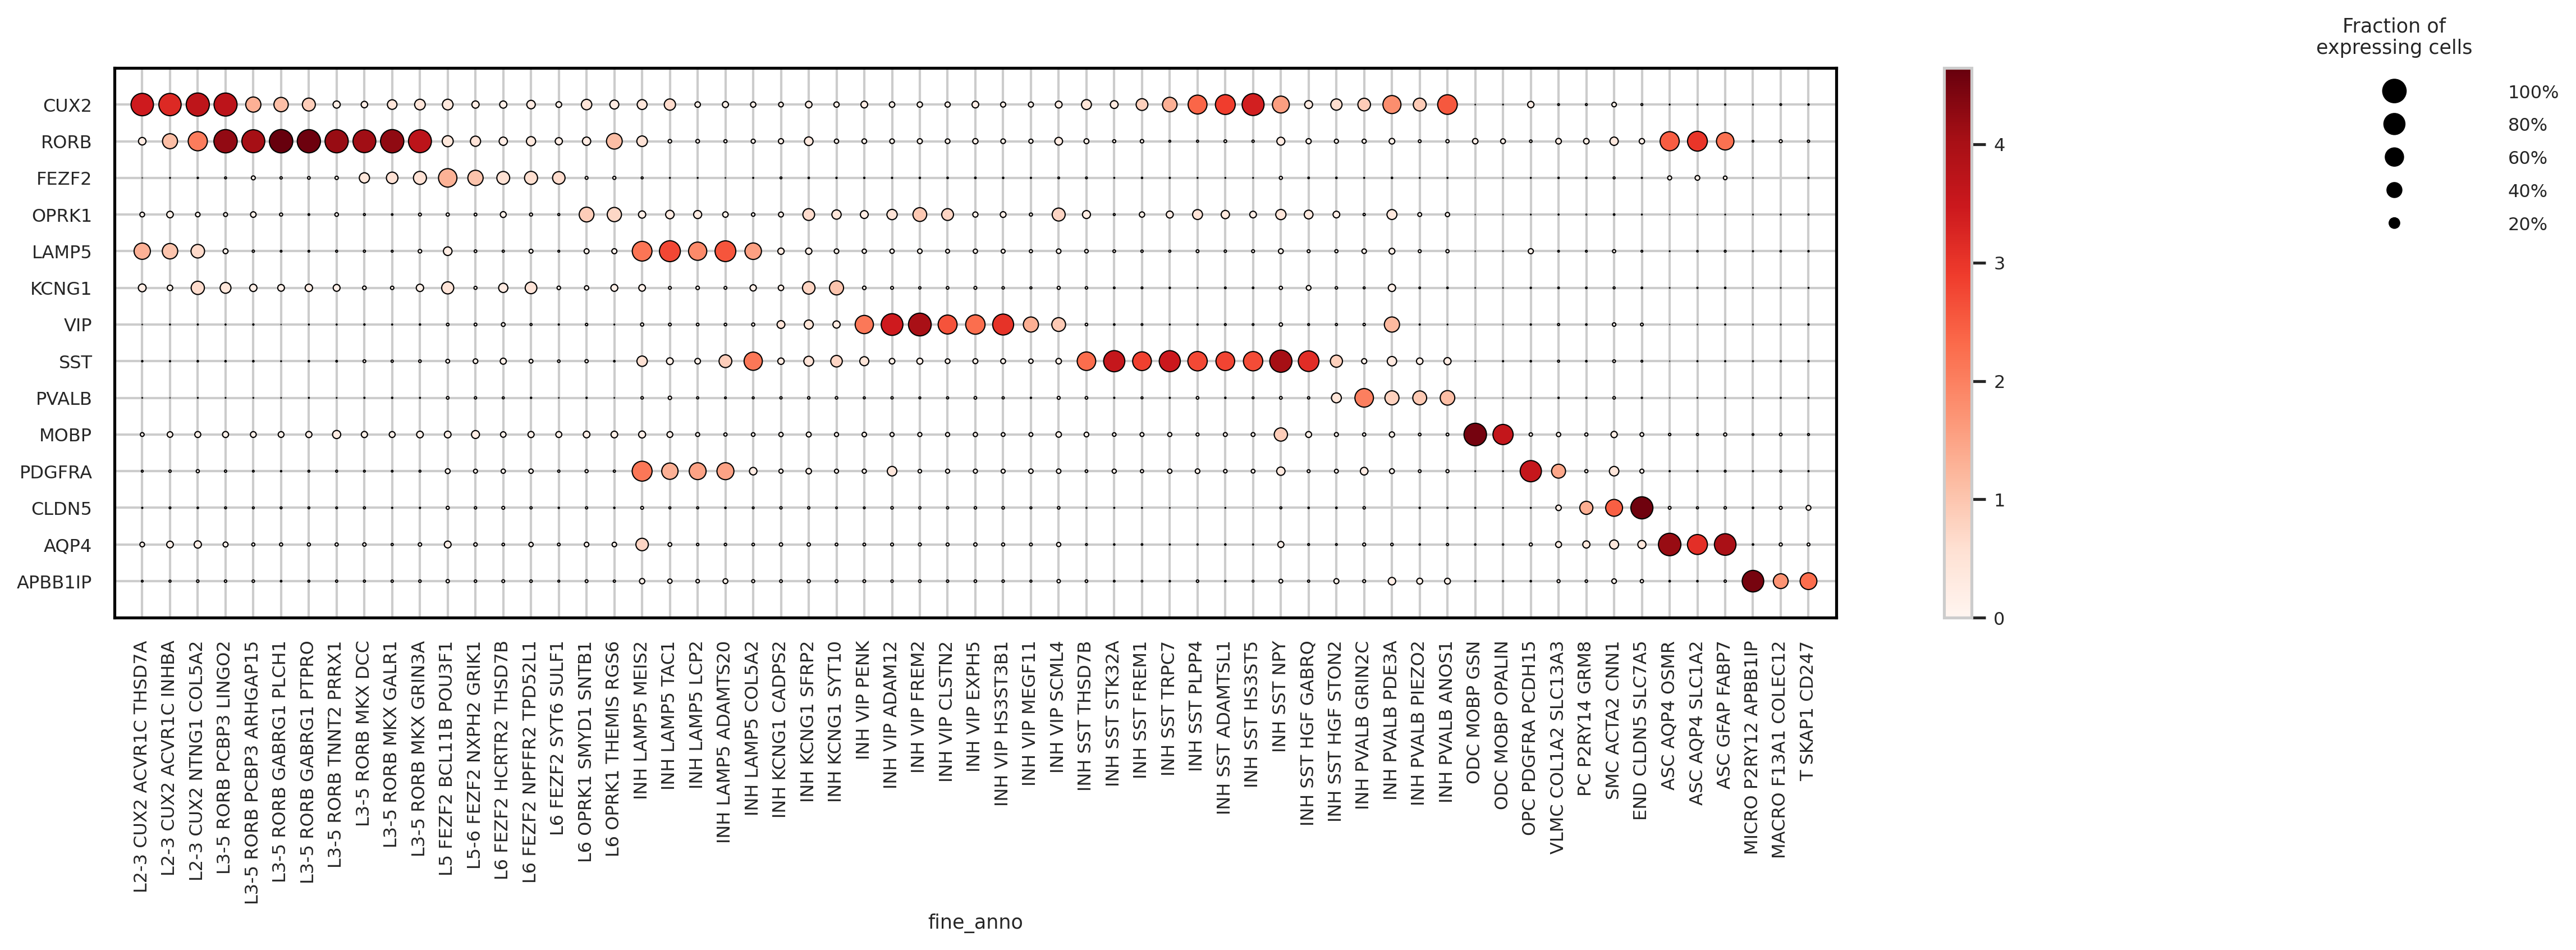

In [26]:
genes = ['CUX2','RORB','FEZF2','OPRK1','LAMP5','KCNG1','VIP','SST','PVALB','MOBP','PDGFRA','CLDN5','AQP4','APBB1IP']
pg.dotplot(data,genes=genes,groupby='fine_anno',sort_function='None',switch_axes=True)
#plt.savefig('/home/ah2428/dotplot.pdf',bbox_inches='tight')

In [53]:
from pegasus.plotting.plot_library import *
import anndata
from pegasusio import UnimodalData, MultimodalData
from pandas.api.types import is_numeric_dtype, is_categorical_dtype, is_list_like

from typing import List, Tuple, Union, Optional, Callable
from pegasus.tools import X_from_rep, slicing

import logging
logger = logging.getLogger(__name__)
import seaborn as sns

def heatmap(
    data: Union[MultimodalData, UnimodalData, anndata.AnnData],
    attrs: Union[str, List[str]],
    groupby: str,
    matkey: Optional[str] = None,
    on_average: bool = True,
    switch_axes: bool = False,
    attrs_cluster: Optional[bool] = False,
    attrs_dendrogram: Optional[bool] = True,
    groupby_cluster: Optional[bool] = True,
    groupby_dendrogram: Optional[bool] = True,
    attrs_labelsize: Optional[float] = 10.0,
    groupby_labelsize: Optional[float] = 10.0,
    cbar_labelsize: Optional[float] = 8.0,
    panel_size: Tuple[float, float] = (10, 10),
    return_fig: Optional[bool] = False,
    dpi: Optional[float] = 300.0,
    **kwargs,
) -> Union[plt.Figure, None]:

    if not isinstance(data, anndata.AnnData):
        cur_matkey = data.current_matrix()
    if matkey is not None:
        assert not isinstance(data, anndata.AnnData)
        data.select_matrix(matkey)

    if isinstance(attrs, str):
        attrs = [attrs]

    obs_keys = []
    genes = []
    for key in attrs:
        if key in data.obs:
            assert is_numeric_dtype(data.obs[key])
            obs_keys.append(key)
        else:
            if key not in data.var_names:
                logger.warning(f"Cannot find gene {key}. Please make sure all genes are included in data.var_names before running this function!")
                return None
            genes.append(key)

    clusters = data.obs[groupby].values
    if not is_categorical_dtype(clusters):
        clusters = pd.Categorical(clusters)
    else:
        clusters = clusters.remove_unused_categories()
    df_list = [pd.DataFrame({'cluster_name': clusters})]

    if len(obs_keys) > 0:
        df_list.append(data.obs[obs_keys].reset_index(drop=True))
    if len(genes) > 0:
        expr_mat = slicing(data[:, genes].X)
        df_list.append(pd.DataFrame(data=expr_mat, columns=genes))
    df = pd.concat(df_list, axis = 1)
    attr_names = df.columns[1:].values

    if on_average:
        if not 'cmap' in kwargs.keys():
            kwargs['cmap'] = 'Blues'
        df = df.groupby('cluster_name').mean()
        cluster_ids = df.index
    else:
        cluster_ids = df.pop('cluster_name').values
        if not groupby_cluster:
            idx = cluster_ids.argsort(kind = 'mergesort')
            df = df.iloc[idx, :]  # organize df by category order
            cluster_ids = cluster_ids[idx]

        cell_colors = np.zeros(df.shape[0], dtype=object)
        palette = _get_palette(cluster_ids.categories.size)

        for k, cat in enumerate(cluster_ids.categories):
            cell_colors[cluster_ids == cat] = palette[k]

    if not switch_axes:
        cg = sns.clustermap(
            data=df,
            row_colors=cell_colors if not on_average else None,
            col_colors=None,
            row_cluster=groupby_cluster,
            col_cluster=attrs_cluster,
            linewidths=0,
            yticklabels=cluster_ids if on_average else [],
            xticklabels=attr_names,
            figsize=panel_size,
            **kwargs,
        )
        cg.ax_heatmap.set_ylabel("")
        if attrs_labelsize is not None:
            cg.ax_heatmap.tick_params(axis='x', labelsize=attrs_labelsize, labelrotation=90)
    else:
        cg = sns.clustermap(
            data=df.T,
            row_colors=None,
            col_colors=cell_colors if not on_average else None,
            row_cluster=attrs_cluster,
            col_cluster=groupby_cluster,
            linewidths=0,
            yticklabels=attr_names,
            xticklabels=cluster_ids if on_average else [],
            figsize=panel_size,
            **kwargs,
        )
        cg.ax_heatmap.set_xlabel("")
        cg.ax_heatmap.set_yticklabels(cg.ax_heatmap.get_yticklabels(), rotation=0)
        
        if attrs_labelsize is not None:
            cg.ax_heatmap.tick_params(axis='y', labelsize=attrs_labelsize)

    show_row_dendrogram = (attrs_cluster and attrs_dendrogram) if switch_axes else (groupby_cluster and groupby_dendrogram)
    show_col_dendrogram = (groupby_cluster and groupby_dendrogram) if switch_axes else (attrs_cluster and attrs_dendrogram)

    if show_row_dendrogram:
        cg.ax_heatmap.yaxis.tick_right()
        cg.ax_row_dendrogram.set_visible(True)

        # Avoid overlap of colorbar and row dendrogram.
        color_box = cg.ax_cbar.get_position()
        square_plot = cg.ax_heatmap.get_position()
        print(color_box)
        cg.ax_cbar.set_position((0.3, 0.02, 0.25, 0.02))
        #if square_plot.y1 > color_box.y0:
        #    y_diff = square_plot.y1 - color_box.y0
        #    color_box.y0 = square_plot.y1
        #    color_box.y1 += y_diff
        #    cg.ax_cbar.set_position(color_box)
            
    else:
        cg.ax_heatmap.yaxis.tick_left()
        cg.ax_row_dendrogram.set_visible(False)

        # Move the colorbar to the right-side.
        color_box = cg.ax_heatmap.get_position()
        cg.ax_cbar.set_position((0, 0.25, 0.05, .27))
        cg.ax_cbar.yaxis.set_ticks_position("none")

    if show_col_dendrogram:
        cg.ax_heatmap.xaxis.tick_bottom()
        cg.ax_col_dendrogram.set_visible(True)
    else:
        cg.ax_heatmap.xaxis.tick_top()
        cg.ax_col_dendrogram.set_visible(False)

    cg.ax_cbar.tick_params(labelsize=cbar_labelsize)
    cg.fig.dpi = dpi
    print(cg.fig.axes)
    cg.fig.axes[3].xaxis.label.set_size(8)

    if not on_average:
        if groupby_cluster:
            from matplotlib.patches import Patch
            legend_elements = [Patch(color = color, label = label) for color, label in zip(palette, cluster_ids.categories)]
            cg.ax_heatmap.legend(handles=legend_elements, loc='lower left', bbox_to_anchor = (1.02, 1.02), fontsize = groupby_labelsize)
        else:
            values = cluster_ids.value_counts().values
            ticks = np.cumsum(values) - values / 2
            labels = cluster_ids.categories
            if not switch_axes:
                cg.ax_row_colors.yaxis.tick_left()
                cg.ax_row_colors.set_yticks(ticks)
                cg.ax_row_colors.set_yticklabels(labels, rotation=0)
                cg.ax_row_colors.tick_params(axis='y', left = False, length=10)
            else:
                cg.ax_col_colors.xaxis.tick_top()
                cg.ax_col_colors.set_xticks(ticks)
                cg.ax_col_colors.set_xticklabels(labels, rotation=0)
                cg.ax_col_colors.tick_params(axis='x', top = False, labelsize = groupby_labelsize, length=10)

    if not isinstance(data, anndata.AnnData):
        if cur_matkey != data.current_matrix():
            data.select_matrix(cur_matkey)

    return df, cg

Bbox(x0=0.02, y0=0.8, x1=0.07, y1=0.98)
[<Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='Average gene expression'>]


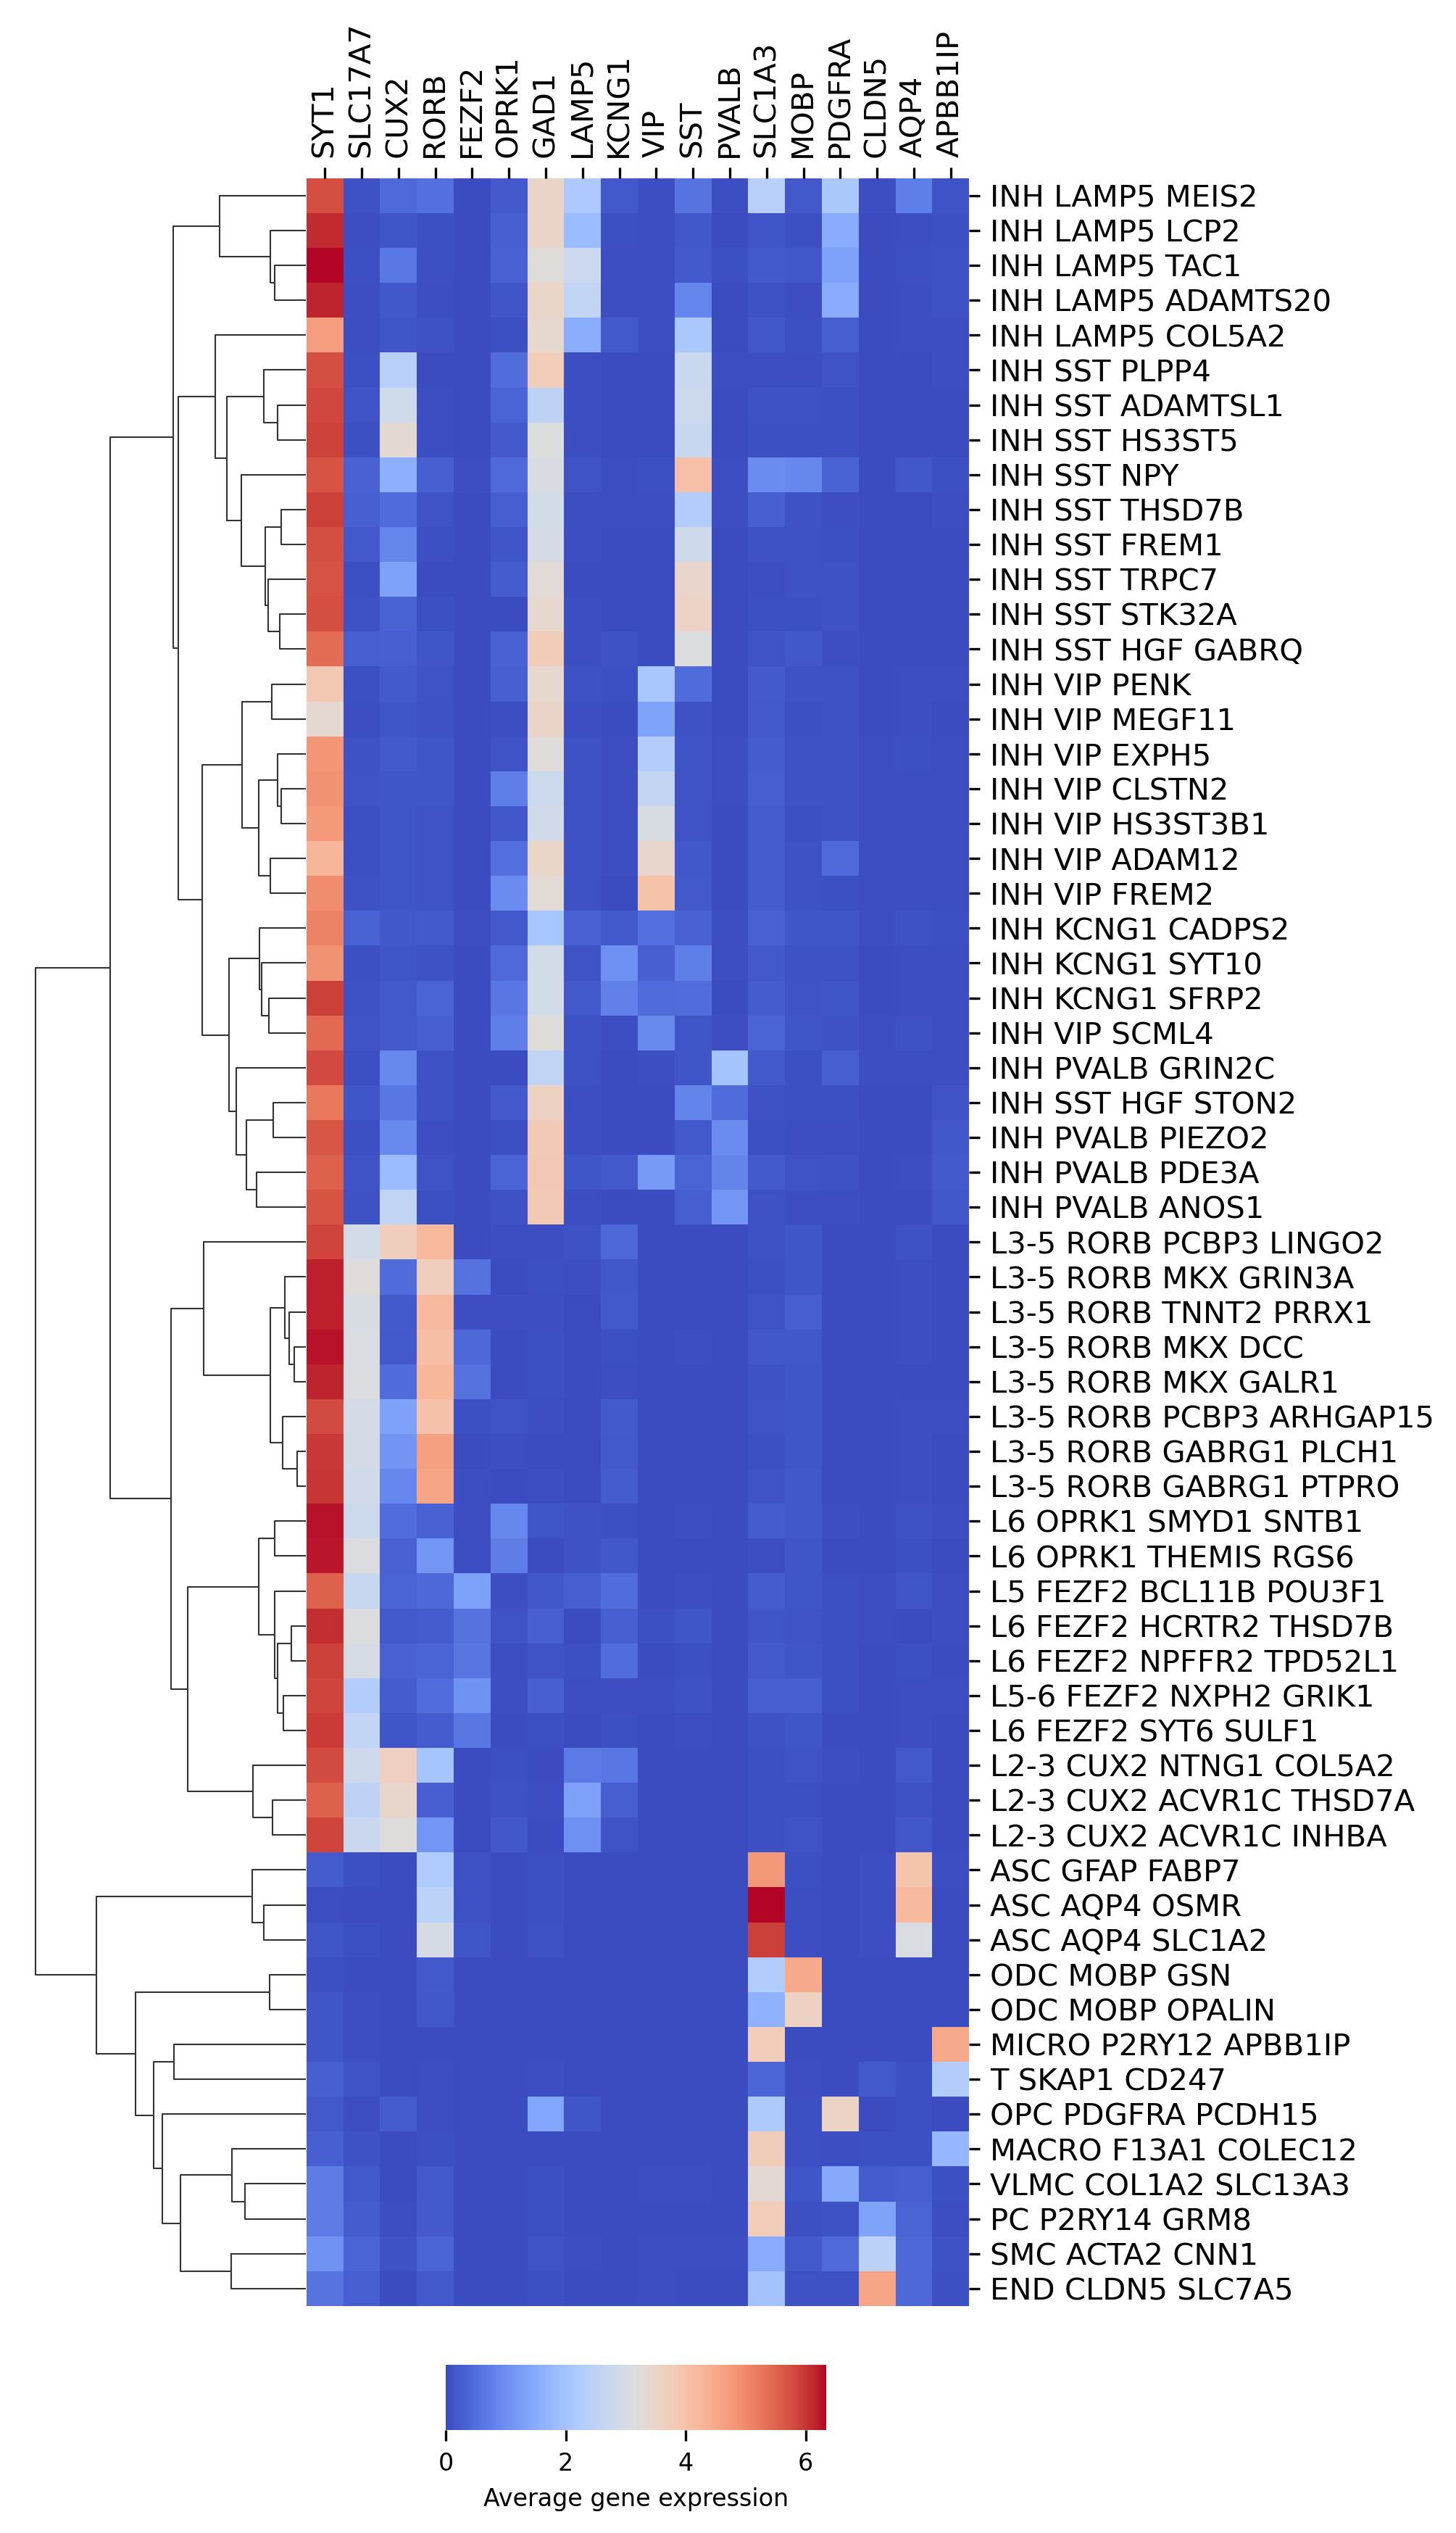

In [76]:
genes = ['SYT1','SLC17A7','CUX2','RORB','FEZF2','OPRK1','GAD1','LAMP5','KCNG1','VIP','SST','PVALB','SLC1A3','MOBP','PDGFRA','CLDN5','AQP4','APBB1IP']

df,cg = heatmap(data, attrs=genes, groupby='fine_anno',cmap='coolwarm',cbar_kws = {'orientation':'horizontal','label':'Average gene expression'},panel_size=(7,15),dendrogram_ratio=0.3)


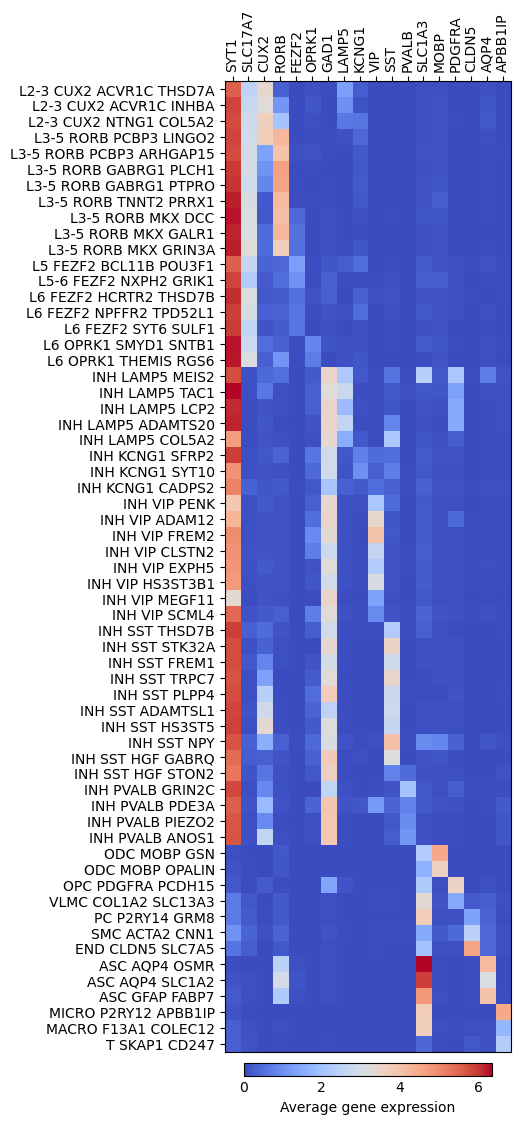

In [77]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots(1,1, figsize=(8,15))

img = ax.imshow(np.array(df),cmap='coolwarm')

x_labels = df.columns
y_labels = df.index
ax.set_xticks(np.arange(len(df.columns)))
ax.set_xticklabels(x_labels,rotation=90)
ax.set_yticks(np.arange(len(df.index)))
ax.set_yticklabels(y_labels)
ax.set_aspect(aspect=1)
ax.xaxis.tick_top()

cb = fig.colorbar(img,shrink=0.4,ticks=None,orientation='horizontal',pad=0.01)
cb.ax.set_xlabel('Average gene expression')
cb.ax.tick_params(size=0)
plt.savefig('/home/ah2428/extended/fine_anno_heatmap.pdf',bbox_inches='tight',dpi=300)

# Extended Data Figure 2d: Fine annotation circos plot

In [2]:
data = pg.read_input('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/RNA/data/RNA_FINAL.zarr')
data

2023-10-15 12:10:06,130 - pegasusio.readwrite - INFO - zarr file '/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/RNA/data/RNA_FINAL.zarr' is loaded.
2023-10-15 12:10:06,131 - pegasusio.readwrite - INFO - Function 'read_input' finished in 350.77s.


MultimodalData object with 1 UnimodalData: 'GRCh38-rna'
    It currently binds to UnimodalData object GRCh38-rna

UnimodalData object with n_obs x n_vars = 935371 x 27982
    Genome: GRCh38; Modality: rna
    It contains 2 matrices: 'X', 'raw.X'
    It currently binds to matrix 'X' as X

    obs: 'n_genes', 'n_counts', 'percent_mito', 'doublet', 'doublet_score', 'Channel', 'scale', 'leiden_labels'(cluster), 'hodge_anno', 'lake_anno', 'nenad_anno', 'fine_anno', 'subclass', 'class', 'BrNum', 'Condition', 'Sex', 'Smoking', 'Antidepressant', 'PMI', 'RIN', 'Race', 'AgeDeath', 'subclass2', 'subclass_renamed', 'subclass_final'
    var: 'featureid', 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'mean', 'var', 'hvf_loess', 'hvf_rank'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'(basis), 'pca_harmony_knn_distances'(knn), 'pca_harmony_knn_indices'(knn)
    varm: 'means', 'partial_sum', 'de_res'
    obsp: 'W_pca_harmony'
    uns: 'genome', 'leiden_resolution', 'modality', 'norm_

In [3]:
from scipy.sparse import issparse

genes = ['CUX2','RORB','FEZF2','OPRK1','LAMP5','KCNG1','VIP','SST','PVALB','MOBP','PDGFRA','CLDN5','AQP4','APBB1IP']

X = slicing(data[:, genes].X)
df = pd.DataFrame(data=X, columns=genes)

groupby='fine_anno'
reduce_function=np.mean
sort_function=None
fraction_min=0
fraction_max=None
sort_function=None

In [4]:
df[groupby] = data.obs[groupby].values
series = df[groupby].value_counts()
idx = series == 0
if idx.sum() > 0:
    logger.warning(f"The following categories contain no cells and are removed: {','.join(list(series.index[idx]))}.")
    df[groupby] = df[groupby].cat.remove_unused_categories()

def non_zero(g):
    return np.count_nonzero(g) / g.shape[0]

summarized_df = df.groupby(groupby).aggregate([reduce_function, non_zero])

row_indices = summarized_df.index.tolist()
if sort_function == "natsorted":
    row_indices = natsorted(row_indices)
elif callable(sort_function):
    row_indices = sort_function(row_indices)
row_indices.reverse()
summarized_df = summarized_df.loc[row_indices]

mean_columns = []
frac_columns = []
for j in range(len(summarized_df.columns)):
    if j % 2 == 0:
        mean_columns.append(summarized_df.columns[j])
    else:
        frac_columns.append(summarized_df.columns[j])
        
# Genes on columns, groupby on rows
fraction_df = summarized_df[frac_columns]
mean_df = summarized_df[mean_columns]

y, x = np.indices(mean_df.shape)
y = y.flatten()
x = x.flatten()
fraction = fraction_df.values.flatten()
if fraction_max is None:
    fraction_max = fraction.max()

pixels = []
for f in fraction:
    new_value = ( (f - summarized_df.min().min()) / (summarized_df.max().max() - summarized_df.min().min()) ) * (100 - 0) + 0
    pixels.append(new_value)

summary_values = mean_df.values.flatten()

xlabel = [genes[i] for i in range(len(genes))]
ylabel = [str(summarized_df.index[i]) for i in range(len(summarized_df.index))]

xticks = genes
yticks = summarized_df.index.map(str).values

dotplot_df = pd.DataFrame(data=dict(x=x, y=y, value=summary_values, pixels=pixels, fraction=fraction,
                xlabel=np.array(xlabel)[x], ylabel=np.array(ylabel)[y]))
dot_min=0
dot_max=20
dpi=300
cmap='Reds'

ValueError: s must be a scalar, or float array-like with the same size as x and y

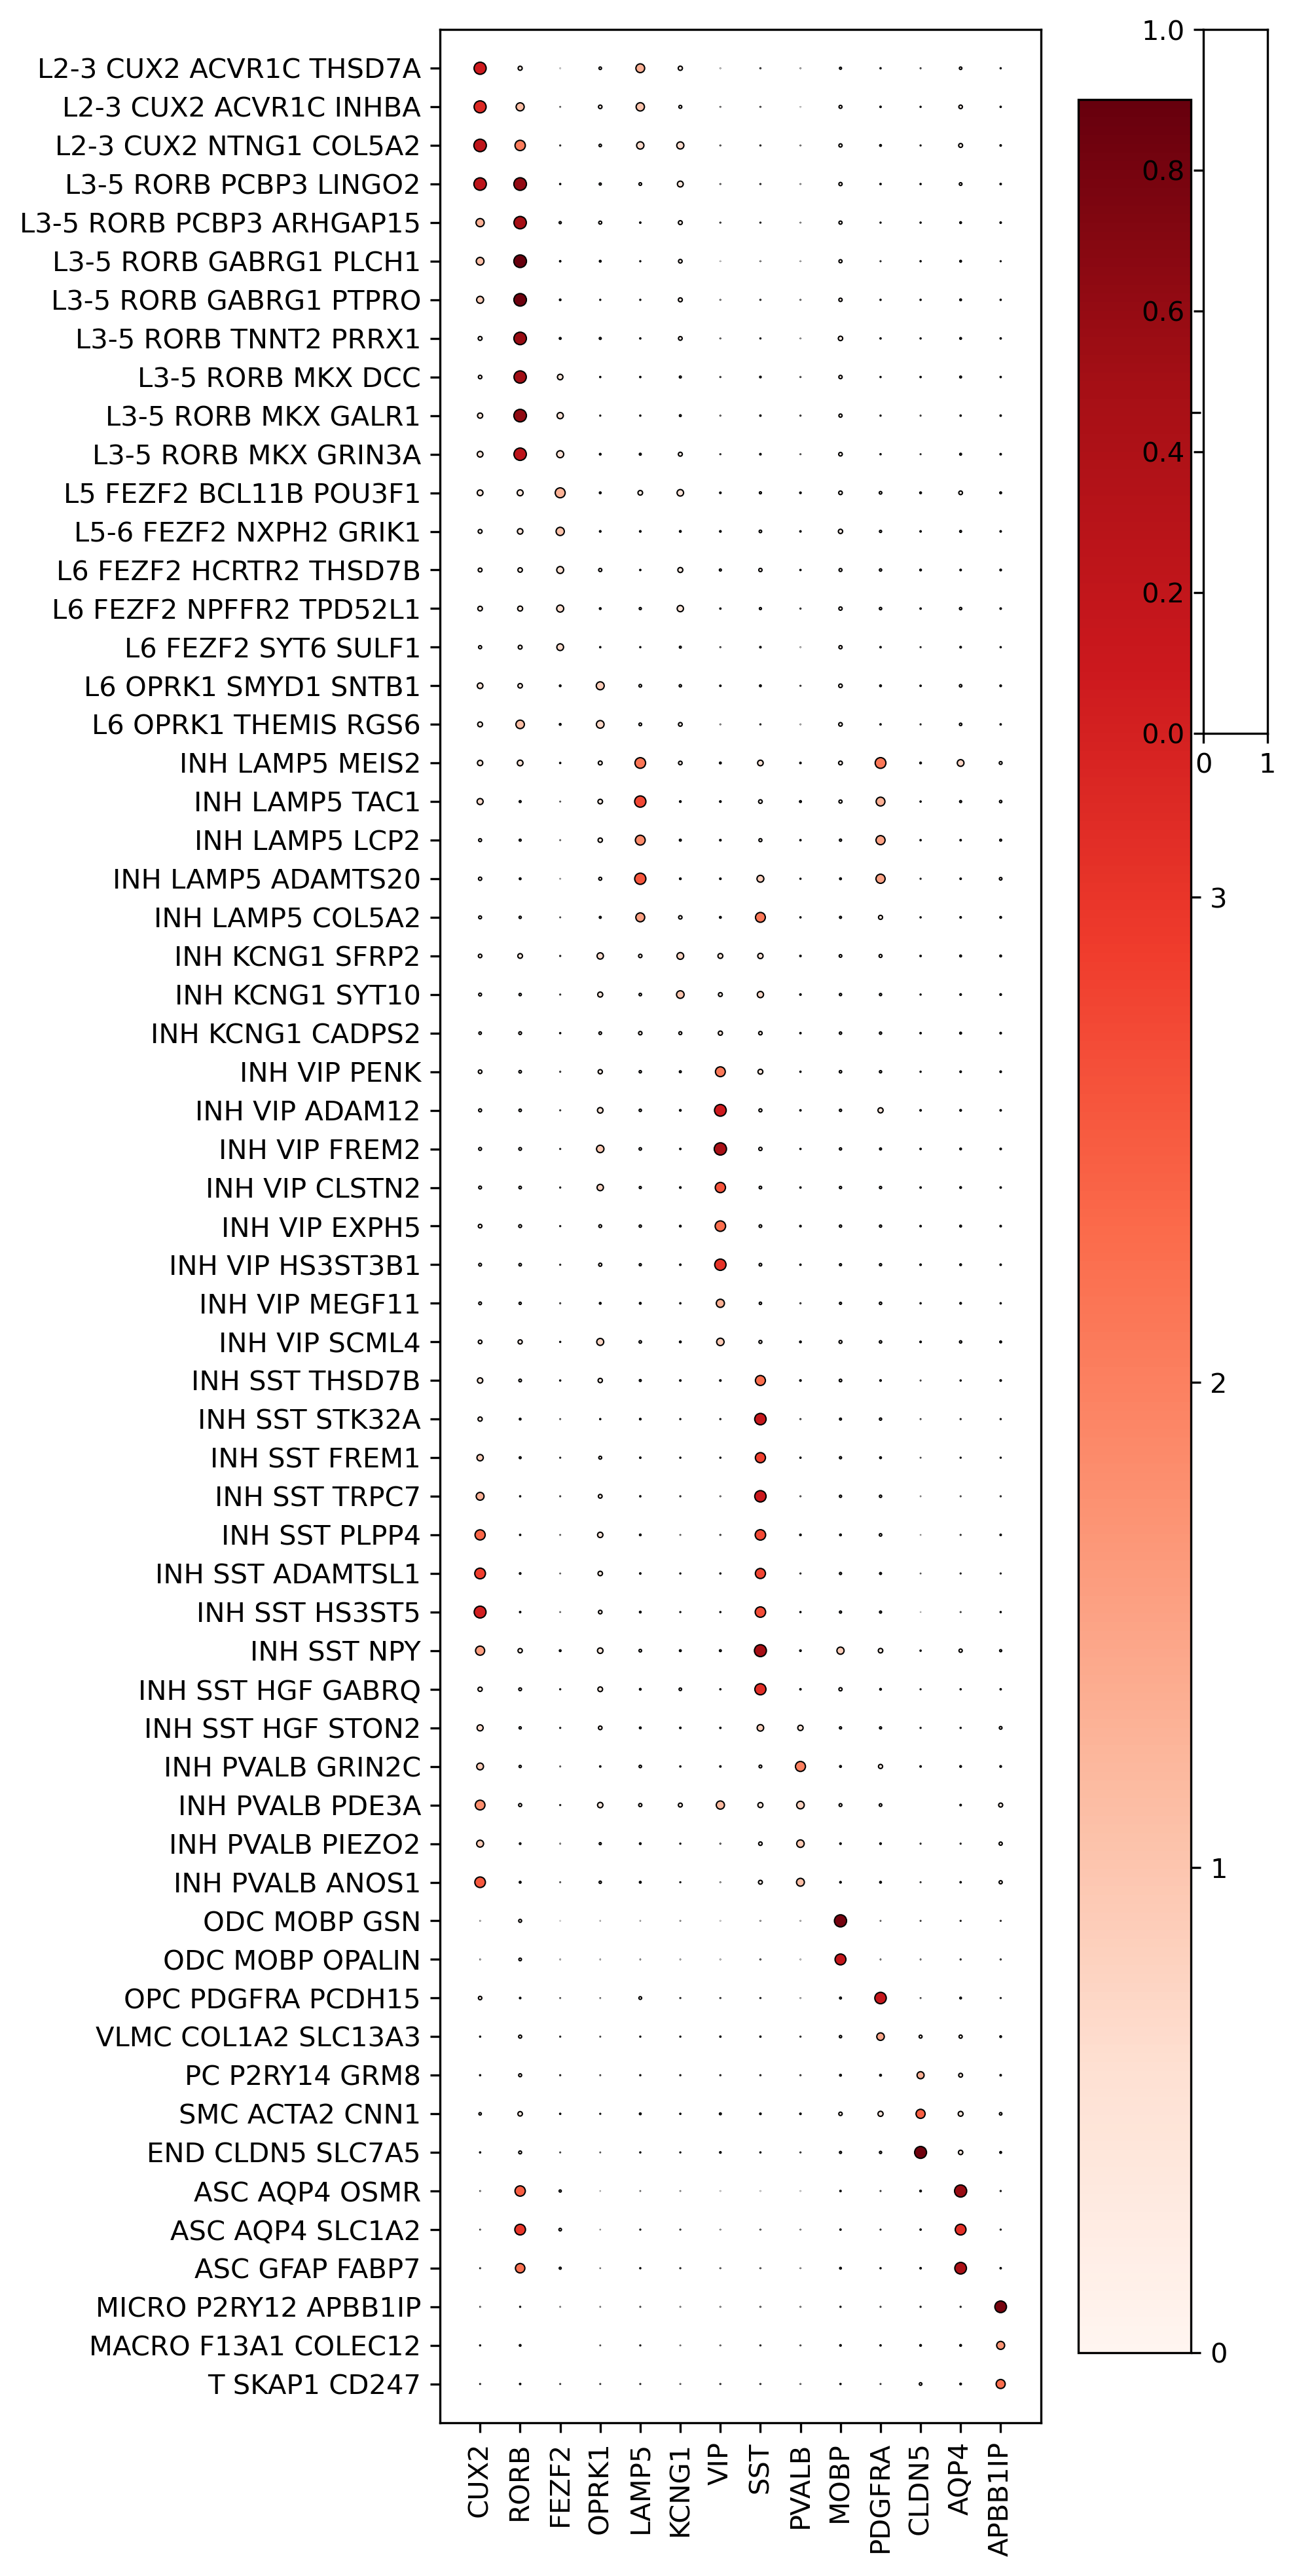

In [5]:
import matplotlib.gridspec as gridspec

width = int(np.ceil(((dot_max + 1) + 4) * len(xticks) + dotplot_df['ylabel'].str.len().max()) + dot_max + 100)
height = int(np.ceil(((dot_max + 1) + 4) * len(yticks) + dotplot_df['xlabel'].str.len().max()) + 50)
fig = plt.figure(figsize=(1.1 * width / 100.0, height / 100.0), dpi=dpi)
gs = gridspec.GridSpec(3, 11, figure = fig)

# Main plot
mainplot_col_grid = -2 if len(xlabel) < 10 else -1
ax = fig.add_subplot(gs[:, :mainplot_col_grid])

sc = ax.scatter(x='x', y='y', c='value', s='pixels', data=dotplot_df, linewidth=0.5, edgecolors='black',cmap='Reds')

ax.spines["top"].set_color('black')
ax.spines["bottom"].set_color('black')
ax.spines["left"].set_color('black')
ax.spines["right"].set_color('black')

ax.set_xlim(-1, len(xticks))
ax.set_ylim(-1, len(yticks))
ax.set_xticks(range(len(xticks)))
ax.set_xticklabels(xticks)
ax.set_yticks(range(len(yticks)))
ax.set_yticklabels(yticks)
plt.xticks(rotation=90)

cbar = plt.colorbar(sc)
#cbar.set_label("Mean of\nexpressing cells")

size_range = fraction_max - fraction_min
if 0.3 < size_range <= 0.6:
    size_legend_step = 0.1
elif size_range <= 0.3:
    size_legend_step = 0.05
else:
    size_legend_step = 0.2

size_ticks = np.arange(fraction_min if fraction_min > 0 or fraction_min > 0 else fraction_min + size_legend_step,
    fraction_max + size_legend_step, size_legend_step)

legend_row_grid = 1 if height / 3 > 100 else 3
ax2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0:legend_row_grid, -1])
size_legend = fig.add_subplot(ax2[0])
#size_tick_pixels = _get_dot_size(size_ticks, fraction_min, fraction_max, dot_min, dot_max)
size_tick_pixels = pixels
size_tick_labels = ["{:.0%}".format(x) for x in size_ticks]
size_legend.scatter(x=np.repeat(0, len(size_ticks)), y=np.arange(0, len(size_ticks)), s=size_tick_pixels, c='black', linewidth=0.5)
size_legend.title.set_text("Fraction of\nexpressing cells")
size_legend.set_xlim(-0.1, 0.1)
size_legend.set_xticks([])

ymin, ymax = size_legend.get_ylim()
size_legend.set_ylim(ymin, ymax + 0.5)

size_legend.set_yticks(np.arange(len(size_ticks)))
size_legend.set_yticklabels(size_tick_labels)
size_legend.tick_params(axis='y', labelleft=False, labelright=True)

size_legend.spines["top"].set_visible(False)
size_legend.spines["bottom"].set_visible(False)
size_legend.spines["left"].set_visible(False)
size_legend.spines["right"].set_visible(False)
size_legend.grid(False)

In [6]:
subclass = ['CUX2', 'RORB', 'FEZF2', 'OPRK1', 'LAMP5', 'KCNG1', 'VIP', 'SST', 'PVALB', 'MOBP', 'PDGFRA', 'CLDN5', 'AQP4', 'APBB1IP']

In [7]:
N = len(data.obs['fine_anno'].cat.categories) + 3
theta = np.arange(0, 2 * np.pi, 2*np.pi/N)

areas = []
colors = []
for ii,sub in enumerate(subclass):
    theta = np.arange(0, 2 * np.pi, 2*np.pi/N) 
    area = 5*dotplot_df[dotplot_df.xlabel.str.contains(sub)][::-1].pixels.values
    areas.append(area)
    color = dotplot_df[dotplot_df.xlabel.str.contains(sub)][::-1].value.values
    colors.append(color)
    
for i in range(14):
    areas[i] = np.append(areas[i],[0.,0.,0.])
    colors[i] = np.append(colors[i],[0.,0.,0.])

In [8]:
def circle_points(r, n, t):
    circles = []
    for r, n in zip(r, n):
        x = r * np.cos(t)
        y = r * np.sin(t)
        circles.append(np.c_[x, y])
    return circles

In [9]:
umap = data.obsm['X_umap']
umap = pd.DataFrame(umap)
umap['celltype'] = data.obs['class'].values
umap['subclass'] = data.obs['subclass'].values
umap['fine'] = data.obs['fine_anno'].values

In [10]:
umap = umap.set_index('celltype')
umap = umap.loc[['EXC','INH','OLI','OPC','END','AST','MIC']].reset_index()

In [24]:
celltypes = ['EXN','INH','ODC','OPC','END','ASC','MG']
scolors = []
for a in [0.4]:
    for c in list(class_colors.values()):
        scolor = (np.append(list(matplotlib.colors.to_rgb(c)),a))
        scolors.append(scolor)

In [25]:
classcolors = []
subclasscolors = []
finecolors = []

for celltype,snum,scolor,fnum,fcolor in zip(['EXN','INH','ODC','OPC','END','ASC','MG'],
                                                     [4,5,1,1,1,1,1],scolors,
                                                     [18,30,2,1,4,3,3],list(class_colors.values())):
    classcolor = class_colors[celltype]
    subclasscolor = [scolor]*snum
    finecolor = [fcolor]*fnum
    classcolors.append(classcolor)
    subclasscolors.append(subclasscolor)
    finecolors.append(finecolor)
subclasscolors = list(itertools.chain.from_iterable(subclasscolors))
finecolors = list(itertools.chain.from_iterable(finecolors))

In [26]:
dotcolors = [subclass_colors[x] for x in ['CUX2','RORB','FEZF2','OPRK1','LAMP5','KCNG1','VIP','SST','PVALB','ODC','OPC','END','ASC','MG']]

In [15]:
index=[
 'L2-3 CUX2 ACVR1C THSD7A','L2-3 CUX2 ACVR1C INHBA','L2-3 CUX2 NTNG1 COL5A2',
 'L3-5 RORB PCBP3 LINGO2','L3-5 RORB PCBP3 ARHGAP15','L3-5 RORB GABRG1 PLCH1','L3-5 RORB GABRG1 PTPRO','L3-5 RORB TNNT2 PRRX1','L3-5 RORB MKX DCC','L3-5 RORB MKX GALR1','L3-5 RORB MKX GRIN3A',
 'L5 FEZF2 BCL11B POU3F1','L5-6 FEZF2 NXPH2 GRIK1','L6 FEZF2 HCRTR2 THSD7B','L6 FEZF2 NPFFR2 TPD52L1','L6 FEZF2 SYT6 SULF1',
 'L6 OPRK1 SMYD1 SNTB1','L6 OPRK1 THEMIS RGS6',
    
 'INH LAMP5 MEIS2','INH LAMP5 TAC1','INH LAMP5 LCP2','INH LAMP5 ADAMTS20','INH LAMP5 COL5A2',
 'INH KCNG1 SFRP2','INH KCNG1 SYT10','INH KCNG1 CADPS2',
 'INH VIP PENK','INH VIP ADAM12','INH VIP FREM2','INH VIP CLSTN2','INH VIP EXPH5','INH VIP HS3ST3B1','INH VIP MEGF11','INH VIP SCML4',
 'INH SST THSD7B','INH SST STK32A','INH SST FREM1','INH SST TRPC7','INH SST PLPP4','INH SST ADAMTSL1','INH SST HS3ST5','INH SST NPY','INH SST HGF GABRQ','INH SST HGF STON2',
 'INH PVALB GRIN2C','INH PVALB PDE3A','INH PVALB PIEZO2','INH PVALB ANOS1',
   
 'ODC MOBP GSN','ODC MOBP OPALIN',
 'OPC PDGFRA PCDH15',
 'VLMC COL1A2 SLC13A3','PC P2RY14 GRM8','SMC ACTA2 CNN1','END CLDN5 SLC7A5',
 'ASC AQP4 OSMR','ASC AQP4 SLC1A2','ASC GFAP FABP7',
 'MICRO P2RY12 APBB1IP','MACRO F13A1 COLEC12','T SKAP1 CD247'
 ]

In [16]:
data.obs['fine_anno'] = data.obs['fine_anno'].cat.reorder_categories(index)
data.obs['Condition'] = data.obs['Condition'].cat.reorder_categories(['PTSD','CON','MDD'])

ptsd = data.obs[data.obs.Condition=='PTSD']
ptsd_df = ptsd.fine_anno.value_counts().reindex(index)
con = data.obs[data.obs.Condition=='CON']
con_df = con.fine_anno.value_counts().reindex(index)
mdd = data.obs[data.obs.Condition=='MDD']
mdd_df = mdd.fine_anno.value_counts().reindex(index)

df = pd.DataFrame({'PTSD': ptsd_df.values,'CON': con_df.values,'MDD': mdd_df.values}, index=index)
new_ptsd = df.PTSD/df.sum(axis=1)
new_con = df.CON/df.sum(axis=1)
new_mdd = df.MDD/df.sum(axis=1)
new = pd.DataFrame({'PTSD': new_ptsd.values,'CON': new_con.values,'MDD': new_mdd.values}, index=index)

celltypes = pd.DataFrame(data.obs['class'].value_counts())
celltypes = celltypes.reindex(['EXC','INH','OLI','OPC','END','AST','MIC'])
celltypes2 = pd.DataFrame(data.obs['subclass'].value_counts())
celltypes2 = celltypes2.reindex(subclass)

In [17]:
celltype_labels = ['EXN', 'INH', 'ODC', 'OPC', 'END', 'ASC', 'MG', ' ']

subclass_labels = ['CUX2', 'RORB', 'FEZF2', 'OPRK1', 'LAMP5', 'KCNG1', 'VIP', 'SST', 'PVALB', 'MOBP', 'PDGFRA', 'CLDN5', 'AQP4', 'APBB1IP', ' ']

size = data.obs['fine_anno'].value_counts().reindex(index)

fine_labels = np.append(size.index,[' ',' ',' '])

In [27]:
classcolors.append('white')
subclasscolors.append('white')
finecolors.append('white')

In [19]:
n=len(data.obs['fine_anno'].cat.categories)
subclass_size = [(360/n)*3,(360/n)*8,(360/n)*5,(360/n)*2,
                 (360/n)*5,(360/n)*3,(360/n)*8,(360/n)*10,(360/n)*4,
                 (360/n)*2,(360/n)*1,(360/n)*4,(360/n)*3,(360/n)*3,(360/n)*3]
class_size = [(360/n)*18,(360/n)*30,(360/n)*2,(360/n)*1,(360/n)*4,(360/n)*3,(360/n)*3,(360/n)*3]

In [20]:
t = np.linspace((3/2)*np.pi, 3.5*np.pi, 64)
t = [x+0.12 for x in t]
r = np.linspace(2000,3000,14)[::-1]
n = [64]*14
circles = circle_points(r, n, t)

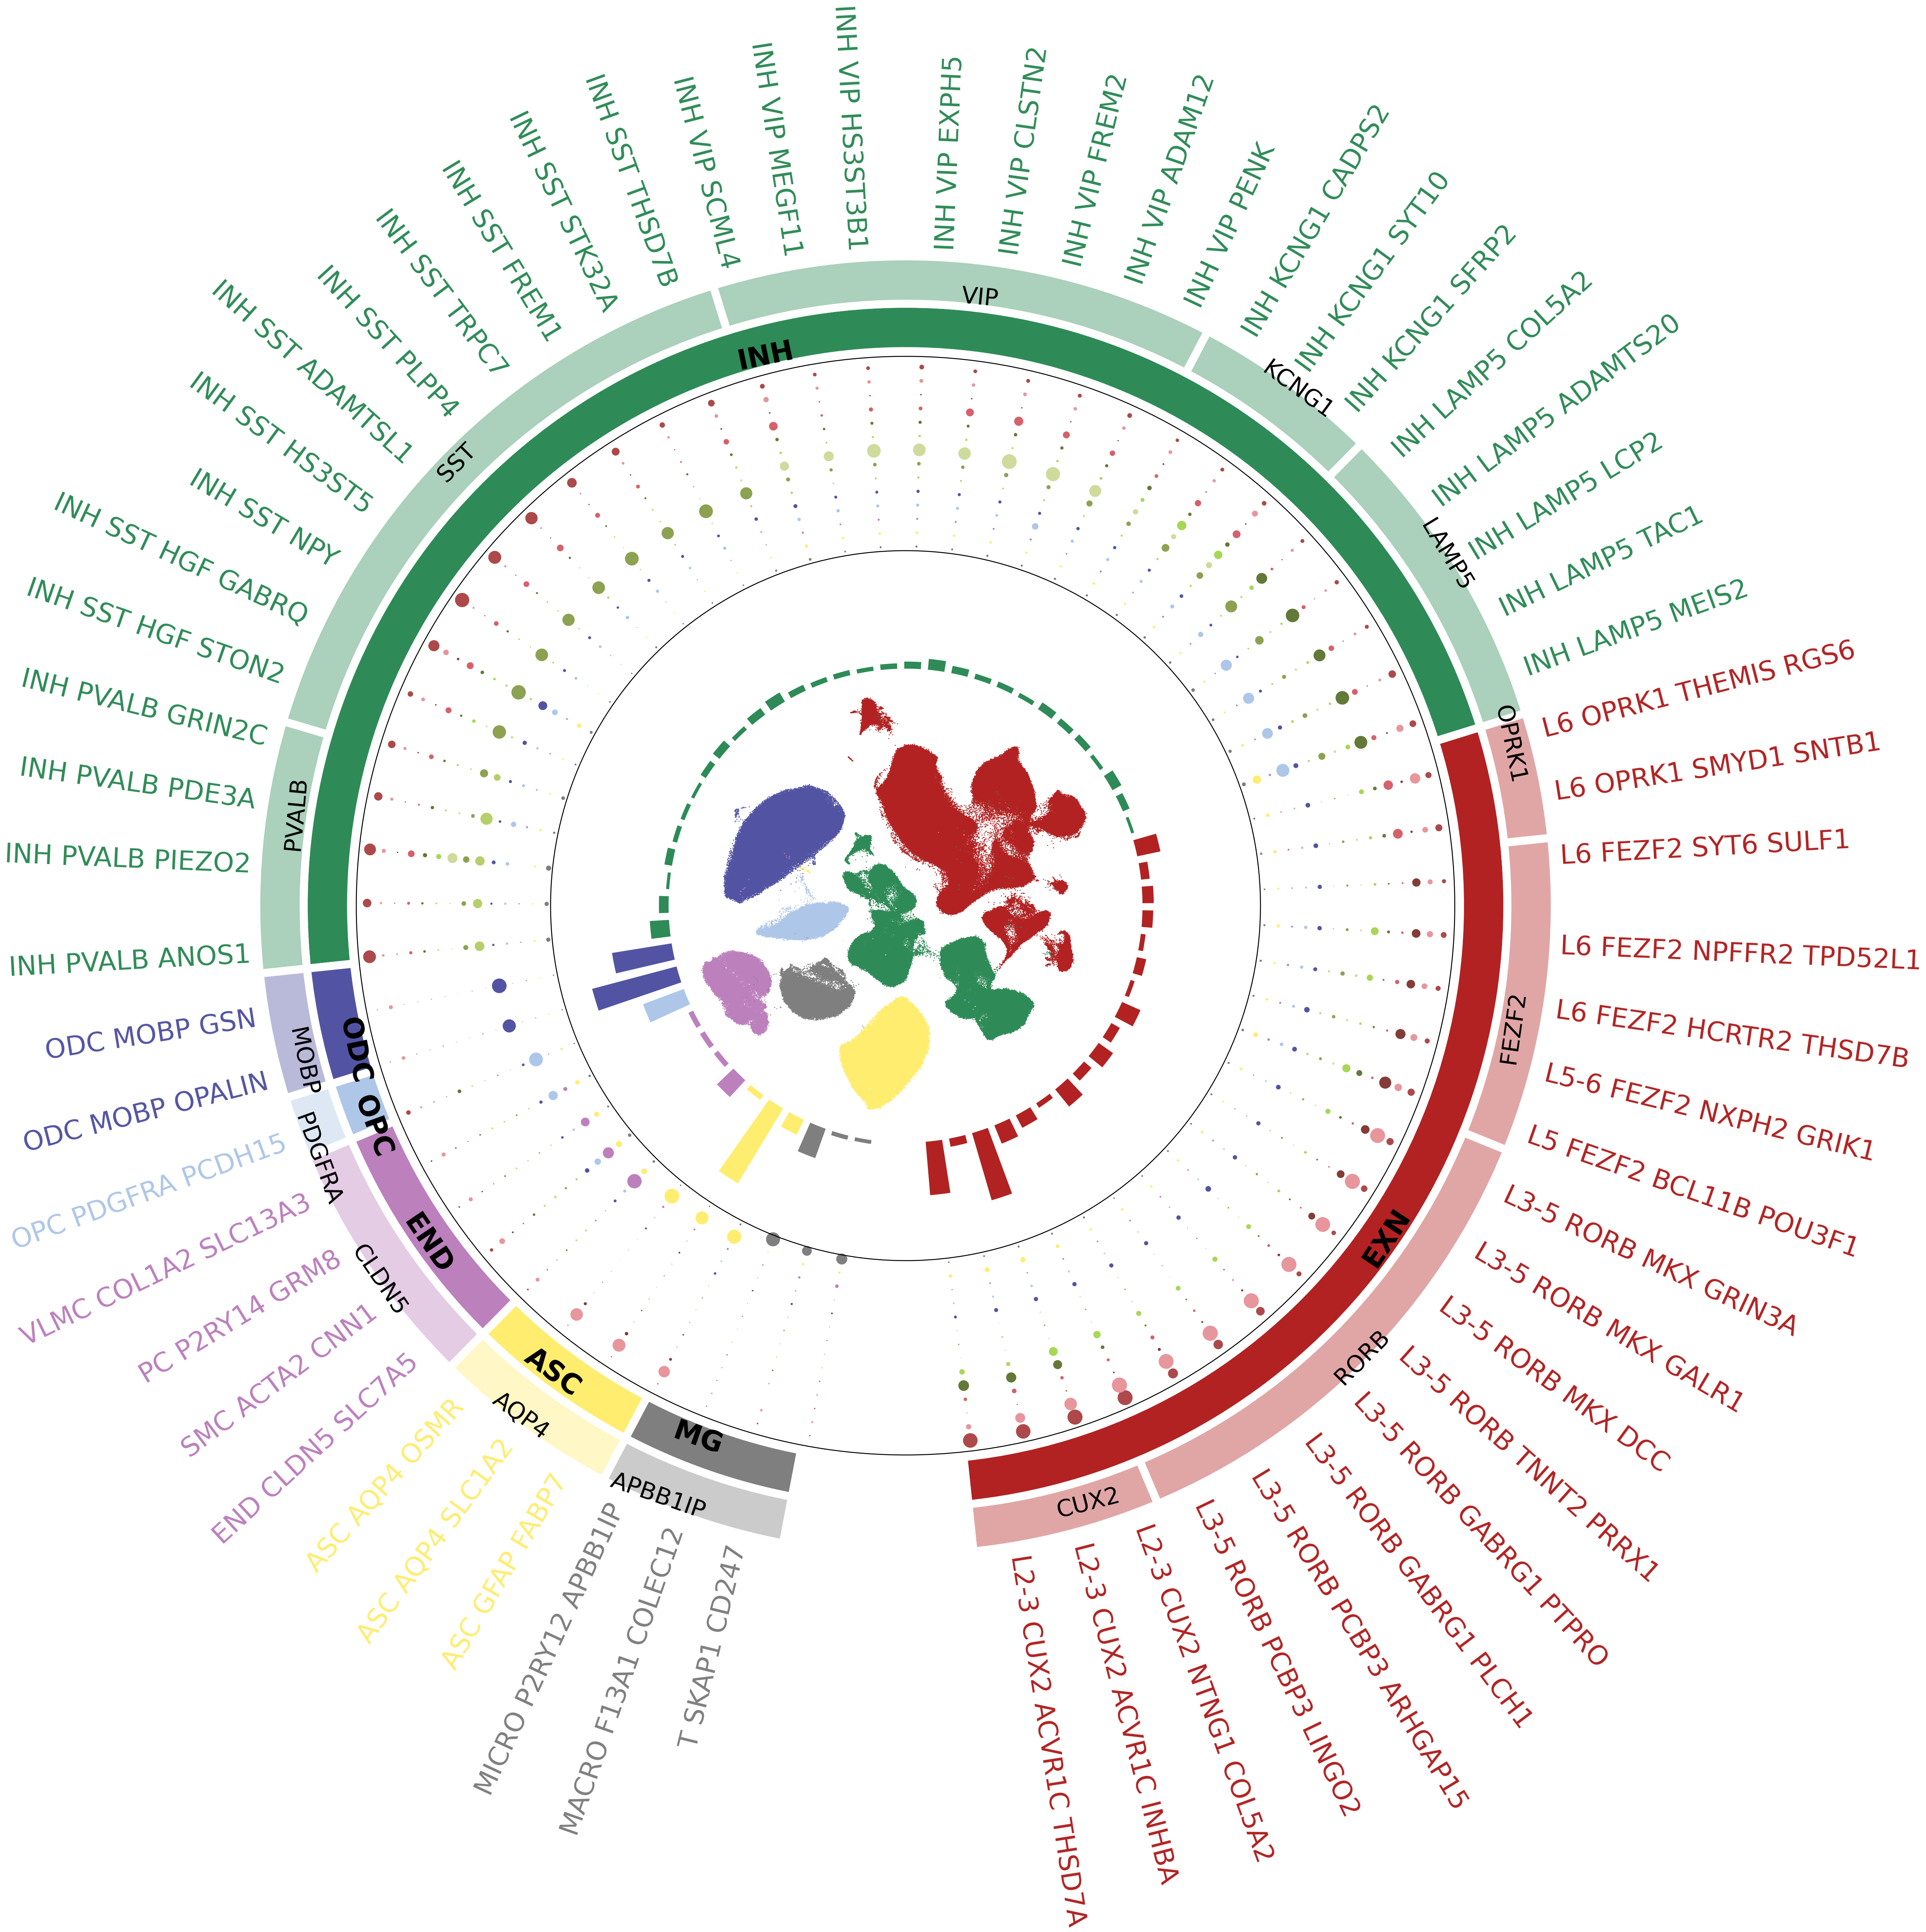

In [29]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots(figsize=(40,40))

cols2 = []
for ii,anno in enumerate(umap.celltype.unique()):
    anno_cols = [classcolors[:7][ii]]*umap[umap.celltype==anno].shape[0]
    cols2.append(anno_cols)
cols2 = list(itertools.chain(*cols2))
ax.set_ylim([-40,55])
ax.set_xlim([-40,55])
ax.scatter(umap[0],umap[1],marker='.',c=cols2,s=4,rasterized=True)
ax.set_frame_on(False)
ax.axis('off')

ax2 = fig.add_subplot()
for ii,circle in enumerate(circles):
    ax2.scatter(circle[:, 0], circle[:, 1], s=areas[ii]*7,c=dotcolors[ii])
ax2.set_aspect('equal')
ax.set_frame_on(False)
ax2.axis('off')

ax6 = fig.add_subplot(polar=True)
ax6.set_ylim([0,2000])

ncells = []
size = data.obs['fine_anno'].value_counts().reindex(index)
vals = (size.values/935371)*150
for val in vals:
    ncell = ( (val - 0.02736882) / (11.52954282 - 0.02736882) ) * (200 - 10) + 10
    ncells.append(ncell)
ncells = np.append(ncells,[0.,0.,0.,])
bars4 = ax6.bar(t, ncells, width=0.07, bottom=800, color=finecolors)
ax6.axis('off')

ax2 = fig.add_subplot()
pie, text = ax2.pie(class_size, labels=celltype_labels, textprops={'fontsize':52,'weight':'bold'}, colors = classcolors, wedgeprops = { 'linewidth' : 15, 'edgecolor' : 'white' }, rotatelabels=True,startangle=276,counterclock=True,labeldistance=0.90,radius=1.27)
plt.setp( pie, width=0.1, edgecolor='white')

ax3 = fig.add_subplot()
pie2, text2 = ax3.pie(subclass_size, labels=subclass_labels, textprops={'fontsize':44}, colors=subclasscolors, wedgeprops = { 'linewidth' : 15, 'edgecolor' : 'white' }, rotatelabels=True,startangle=276,counterclock=True,labeldistance=0.92,radius=1.37)
plt.setp( pie2, width=0.1, edgecolor='white')

ax4 = fig.add_subplot()
pie3, text3 = ax4.pie([360/64]*64, labels=fine_labels, textprops={'fontsize':50}, colors=finecolors, wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' },rotatelabels=True,startangle=276,radius=1.47,labeldistance=0.94)
plt.setp( pie3, width=0, edgecolor='white')

ax5 = fig.add_subplot()
pie4, text4 = ax5.pie(class_size, textprops={'fontsize':50}, colors=['k']*8, wedgeprops = { 'linewidth' : 0, 'edgecolor' : 'white' },rotatelabels=True,startangle=270,radius=1.16)
plt.setp( pie4, width=0.002, edgecolor='white')

ax6 = fig.add_subplot()
pie5, text5 = ax6.pie(class_size, textprops={'fontsize':60}, colors=['k']*8, wedgeprops = { 'linewidth' : 0, 'edgecolor' : 'white' },rotatelabels=True,startangle=280,radius=0.75)
plt.setp( pie5, width=0.002, edgecolor='white')


colors2 = np.append(finecolors[:61],[0.,0.,0.,])
for tx in text:
    rot = tx.get_rotation()
    tx.set_rotation(rot+90+(1-rot//180)*180)
for tx in text2:
    rot = tx.get_rotation()
    tx.set_rotation(rot+90+(1-rot//180)*180)
for ii,text in enumerate(text3):
    text.set_color(colors2[ii])
    
#plt.savefig('/home/ah2428/circos.pdf',bbox_inches='tight',dpi=300)
plt.show()